## Get started

In [13]:
# Note: If you haven't installed the following dependencies, run:
!apt-get install xvfb
!pip install 'gym==0.10.11'
!pip install 'imageio==2.4.0'
!pip install pillow
!pip install pyglet
!pip install pyvirtualdisplay
!pip install tf-agents-nightly
!pip install tf-nightly
!pip install tf-agents-nightly

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


## Introduction

This example shows how to train a [DQN (Deep Q Networks)](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) agent on the Cartpole environment using the TF-Agents library.

We will walk you through all the compoments in a Reinforcement Learning (RL) pipeline for training, evaluation and data collection.

## Setup

In [0]:
from __future__ import absolute_import, division, print_function

import base64

import imageio

import IPython

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image

import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [15]:
print(tf.__version__)
import tf_agents
print(tf_agents.__version__)

1.15.0-dev20190706
0.2.0


In [0]:
tf.compat.v1.enable_v2_behavior()

In [17]:
# Setup a virtual display for rendering OpenAI gym environments
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

W0706 12:33:48.242400 139627434522496 abstractdisplay.py:151] xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [0]:
env_name = 'CartPole-v0'
num_iterations = 20_000

initial_collect_steps = 1_000
collect_steps_per_iteration = 1
replay_buffer_capacity = 100_000

fc_layer_params = (100, )

batch_size = 64
learning_rate = 1e-3
log_interval = 200

num_eval_episodes = 10
eval_interval = 1_000

## Environment

Environments in RL represent the task or problem that we are trying to solve. Standard environments can be easily created in TF-Agents using `suites`. We have different `suites` for loading environments from sources such as OpenAI Gym, Atari, DM Control, etc., given a string environment name.

Now let us load the CartPole environment from the OpenAI Gym suite.

In [0]:
env = suite_gym.load(env_name)

We can render this environment to see how it looks. A free-swinging pole is attached to a cart. The goal is to move the cart right or left in order to keep the pole pointing up.

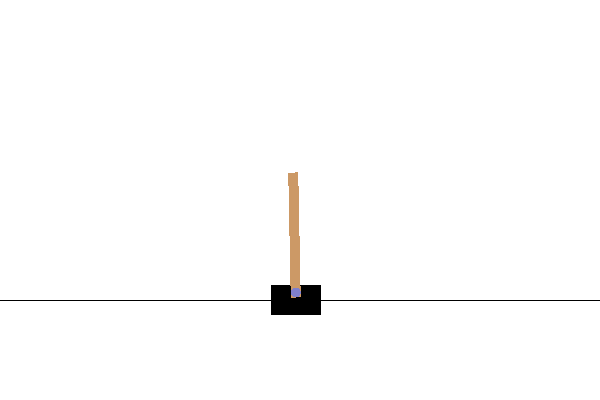

In [20]:
#@test {'skip': True}
env.reset()
PIL.Image.fromarray(env.render())

The `time_step = environment.step(action)` statement takes `action` in the environment. The `TimeStep` tuple returned contains the environment's next observation and reward for that action. The `time_step_spec()` and `action_spec()` methods in the environment return the specifications (types, shape, bounds) of the `time_step` and `action` respectively.

In [21]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name=None, minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name=None, minimum=0, maximum=1)


So, we see that observation is an array of 4 floats: the position and velocity of the cart, and the angular position and velocity of the pole. Since only two actions are possible (move left or move right), the `action_spec` is a scalar where 0 means "move left" and 1 means "move right".

In [22]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = 1

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([-0.03183455,  0.00841332,  0.00802744, -0.02137931], dtype=float32))
Next time step:
TimeStep(step_type=array(1, dtype=int32), reward=array(1., dtype=float32), discount=array(1., dtype=float32), observation=array([-0.03166628,  0.20341924,  0.00759986, -0.3115187 ], dtype=float32))


Usually we create two environments: one for training and one for evaluation. Most environments are written in pure Python, but they can be easily converted to Tensorflow using the `TFPyEnvironment` wrapper. The original environment's API uses numpy arrays, the `TFPyEnvironment` converts these to/from `Tensors` for you to more easily interact with Tensorflow policies and agents.

In [0]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

The algorithm that we use to solve an RL problem is represented as an `Agent`. In addition to the DQN agent, TF-Agents provides standard implementations of a variety of `Agents` such as [REINFORCE](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf), [DDPG](https://arxiv.org/pdf/1509.02971.pdf), [TD3](https://arxiv.org/pdf/1802.09477.pdf), [PPO](https://arxiv.org/abs/1707.06347) and [SAC](https://arxiv.org/abs/1801.01290).

The DQN agent can be used in any environment which has a discrete action space. To create a DQN Agent, we first need a `Q-Network` that can learn to predict `Q-Values` (expected return) for all actions given an observation from the environment.

We can easily create a `Q-Network` using the specs of the observations and actions. We can specify the layers in the network which, in this example, is the `fc_layer_params` argument set to a tuple of `ints` representing the sizes of each hidden layer (see the Hyperparameters section above).

In [0]:
q_net = q_network.QNetwork(
    input_tensor_spec=train_env.observation_spec(),
    action_spec=train_env.action_spec(),
    fc_layer_params=fc_layer_params,
)

We also need an `optimizer` to train the network we just created, and a `train_step_counter` variable to keep track of how many times the network was updated.

In [27]:
type(q_net)

tf_agents.networks.q_network.QNetwork

In [0]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = dqn_agent.DqnAgent(
    time_step_spec=train_env.time_step_spec(),
    action_spec=train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=dqn_agent.element_wise_squared_loss,
    train_step_counter=train_step_counter,
)

## Policies

In TF-Agents, policies represent the standard notion of policies in RL: given a `time_step` produce an action or a distribution over actions. The main method is `policy_step = policy.step(time_step)` where `policy_step` is a named tuple `PolicyStep(action, state, info)`. The `policy_step.action` is the `action` to be applied to the environment, `state` represents the state for stateful (RNN) policies and `info` may contain auxiliary information such as log probabilities of the actions.

Agents contain two policies: the main policy that is used for evaluation/deployment (agent policy) and another policy that is used for data collection (agent.collect_policy).

In [0]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

We can also independently create policies that are not part of an agent. For example, a random policy:

In [0]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())

## Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode, and we usually average this over a few episodes. We can compute the average return metric as follows.

In [32]:
#@test {'skip': True}
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return
    
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

compute_avg_return(eval_env, random_policy, num_eval_episodes)

# Please also see the metrics module for standard implementations of different metrics

19.0

## Replay Buffer

In order to keep track of the data collected from the environment, we will use the `TFUniformReplayBuffer`. This replay buffer is constructed using specs describing the tensors that are to be stored, which can be obtained from the agent using `tf_agent.collect_data_spec`.

In [0]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity,
)

For most agents, the `collect_data_spec` is a `Trajectory` named tuple containing the observation, action, reward, etc.

## Data Collection

Now let us execute the random policy in the environment for a few steps and record the data (observations, actions, rewards, etc.) in the replay buffer.

In [0]:
#@test {'skip': True}
def collect_step(environment, policy):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    
    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

for _ in range(initial_collect_steps):
    collect_step(train_env, random_policy)
    
# This loop is so common in RL, that we provide standard implementations of these.
# For more details see the drivers module.

In order to sample data from the replay buffer, we will create a `tf.data` pipeline which we can feed to the agent for training later. We can specify the `sample_batch_size` to configure the number of items sampled from the replay buffer. We can also optimize the data pipeline using parallel calls and prefetching.

In order to save space, we only store the current observation in each row of the replay buffer. But since the DQN Agent needs both the current and next observation to compute the loss, we always sample two adjacent rows for each item in the batch by setting `num_steps=2`.

In [0]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2,
).prefetch(3)

iterator = iter(dataset)

## Training the agent

The training loop involves both collecting data from the environment and optimizing the agent's networks. Along the way, we will occasionally evaluate the agent's policy to see how we are doing.

The following will take ~5 minutes to run

In [36]:
#@test {'skip': True}
%%time

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):
    # collect a few steps using collect_policy and save to the replay buffer
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, tf_agent.collect_policy)
    
    # sample a batch of data from the buffer and update the agent's network
    experience, unused_info = next(iterator)
    train_loss = tf_agent.train(experience)
    
    step = tf_agent.train_step_counter.numpy()
    
    if step % log_interval == 0:
        print(f'step = {step}: loss = {train_loss.loss}')
        
    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
        
        print(f'step = {step}: Average Return = {avg_return}')
        returns.append(avg_return)

W0706 13:40:34.120270 139627434522496 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_agents/policies/epsilon_greedy_policy.py:96: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0706 13:40:34.310968 139627434522496 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/training/optimizer.py:172: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


step = 200: loss = 30.490049362182617
step = 400: loss = 13.434477806091309
step = 600: loss = 35.6773796081543
step = 800: loss = 9.577139854431152
step = 1000: loss = 19.14862823486328
step = 1000: Average Return = 42.0
step = 1200: loss = 14.721395492553711
step = 1400: loss = 20.15286636352539
step = 1600: loss = 31.054426193237305
step = 1800: loss = 44.02198791503906
step = 2000: loss = 53.10308074951172
step = 2000: Average Return = 23.799999237060547
step = 2200: loss = 67.30393981933594
step = 2400: loss = 43.63457107543945
step = 2600: loss = 36.713409423828125
step = 2800: loss = 57.68275833129883
step = 3000: loss = 90.59750366210938
step = 3000: Average Return = 82.0999984741211
step = 3200: loss = 22.643049240112305
step = 3400: loss = 60.850921630859375
step = 3600: loss = 48.426048278808594
step = 3800: loss = 11.080589294433594
step = 4000: loss = 49.23651885986328
step = 4000: Average Return = 89.9000015258789
step = 4200: loss = 61.190879821777344
step = 4400: loss =

## Visualization

### Plots

We can plot return vs global steps to see the performance of our agent. In `Cartpole-v0`, the environment gives a reward of +1 every time step the pole stays up, and since the maximum number of steps is 200, the maximum possible is also 200.

(-0.025000000000000355, 250)

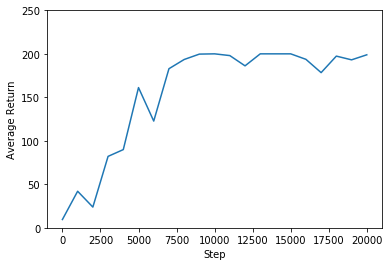

In [37]:
#@test {'skip': True}

steps = range(0, num_iterations+1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=250)

### Videos

It is helpful to visualize the performance of an agent by rendering the environment the environment at each step. Before we do that, let us create a function to embed videos in this colab.

In [0]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename, 'rb').read()
    b64 = base64.b64encode(video)
    tag = f'''
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{b64}" type="video/mp4">
        Your browser does not support the video tag.
    </video>
    '''
    
    return IPython.display.HTML(tag)

The following code visualizes the agent's policy for a few episodes:

In [39]:
num_episodes = 3
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
    for _ in range(num_episodes):
        time_step = eval_env.reset()
        video.append_data(eval_py_env.render())
        while not time_step.is_last():
            action_step = tf_agentb.policy.action(time_step)
            time_step = eval_env.step(action_step.action)
            video.append_data(eval_py_env.render())
            
embed_mp4(video_filename)

W0706 14:11:05.992955 139627434522496 ffmpeg.py:839] IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (400, 600) to (400, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to None (risking incompatibility). You may also see a FFMPEG warning concerning speedloss due to data not being aligned.


In [0]:
import os

In [41]:
os.listdir('.')

['.config', 'imageio.mp4', 'sample_data']

In [0]:
from google.colab import drive

In [ ]:
drive.mount('/gdriveb')

In [44]:
os.listdir('/gdrive')

['Shared drives', 'My Drive', '.Trash']

In [0]:
import shutil

In [46]:
shutil.move('imageio.mp4', '/gdrive/My Drive/CartPole-v0_eval.mp4')

'/gdrive/My Drive/CartPole-v0_eval.mp4'

<video src="CartPole-v0_eval.mp4" controls></video>